<div style="text-align: right"> Brian Wiley <br/>
EN.705.601.3VL.SP20 Applied Machine Learning </div>

## Assignment 3
### Applied Machine Learning

__1. [10 pts] Due to the severity of this real-world crisis, what information would be the most
important one to "machine learn"? Can it be learned?__

I am going to do some experiments and then answer along the way and summarize at end of exploration for this question.

In [1]:
## imports and get data

import pandas as pd
import numpy as np
import seaborn as sns;
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/master.csv')

print(df.shape)
print(df.dtypes)
print(sum(df.duplicated()))
df.head(5)

(27820, 12)
country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
country-year           object
HDI for year          float64
 gdp_for_year ($)      object
gdp_per_capita ($)      int64
generation             object
dtype: object
0


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [2]:
## is there issue with the 'boomers' generation? I see three age group gaps
df[df['generation']=='Boomers']['age'].value_counts()

35-54 years    3030
25-34 years    1154
55-74 years     806
Name: age, dtype: int64

I noticed by looking at different mappings further below for `age` group and `generation` because `.astype('category').cat.codes` was not giving floats in the correct <u>ordinal</u> order which is what I believe these categories should be if we were looking at them as categorical, that the generations column is wrong in that you should not have 4 different age groups for 1 generation.  "Generations" in the normal way of the term do not spread over 40 years as shown by the example below for `Generation X`.  After researching on Kaggle, I found this was a derived column

In [3]:
## so I noticed this looking at data the generations are messed up 
## you may have 3-4 generations indicated for a single ten year age group
grouped = df.groupby(['generation', 'age']).agg({'generation':'count'})
grouped

generation
generation      age                    
Boomers         25-34 years        1154
                35-54 years        3030
                55-74 years         806
G.I. Generation 55-74 years         630
                75+ years          2114
Generation X    15-24 years        2114
                25-34 years        2682
                35-54 years         982
                5-14 years          630
Generation Z    5-14 years         1470
Millenials      15-24 years        2528
                25-34 years         806
                5-14 years         2510
Silent          35-54 years         630
                55-74 years        3206
                75+ years          2528


Let's look at the countries with the top 20 highest suicide rates and for fun instead of using `suicides/100k pop` let's try a calculated rate of $\frac{suicides\_no}{population}$ and see if the group is very different from the top 20 `suicides/100k pop` average by country.  This could be an indicator is there is a huge data error with `suicides/100k pop`.


In [4]:
## which top countries have the top 20 suicide rates for all years combined
country_calc = df.groupby(['country']).agg({'suicides_no': 'sum', 'population': 'sum'})
country_calc['suicide_rate'] = country_calc['suicides_no'] / country_calc['population']
top20_calc = country_calc.sort_values(by='suicide_rate', ascending=False).index[:20]
top20_calc

Index(['Lithuania', 'Russian Federation', 'Sri Lanka', 'Belarus', 'Hungary',
       'Latvia', 'Kazakhstan', 'Slovenia', 'Estonia', 'Ukraine', 'Finland',
       'Japan', 'Belgium', 'Guyana', 'Austria', 'Croatia', 'France',
       'Mongolia', 'Republic of Korea', 'Serbia'],
      dtype='object', name='country')

In [49]:
country = df.groupby(['country']).agg({'suicides/100k pop': 'mean', 'population': 'count'})
top20 = country.sort_values(by='suicides/100k pop', ascending=False).index[:20]
print(top20)
print('\n', len(top20_calc.intersection(top20)), 'out of 20 intersect')

Index(['Lithuania', 'Sri Lanka', 'Russian Federation', 'Hungary', 'Belarus',
       'Kazakhstan', 'Latvia', 'Slovenia', 'Estonia', 'Ukraine',
       'Republic of Korea', 'Austria', 'Croatia', 'Finland', 'Guyana',
       'Serbia', 'France', 'Japan', 'Suriname', 'Belgium'],
      dtype='object', name='country')

 19 out of 20 intersect


OK the calculated rates based on two columns are are not that different from `suicides/100k pop` column.  Good.  Now lets graph the `suicide_rate` that we calculated for the top 20 countries with highest rates and see is there is some discriminating power based on `sex`.

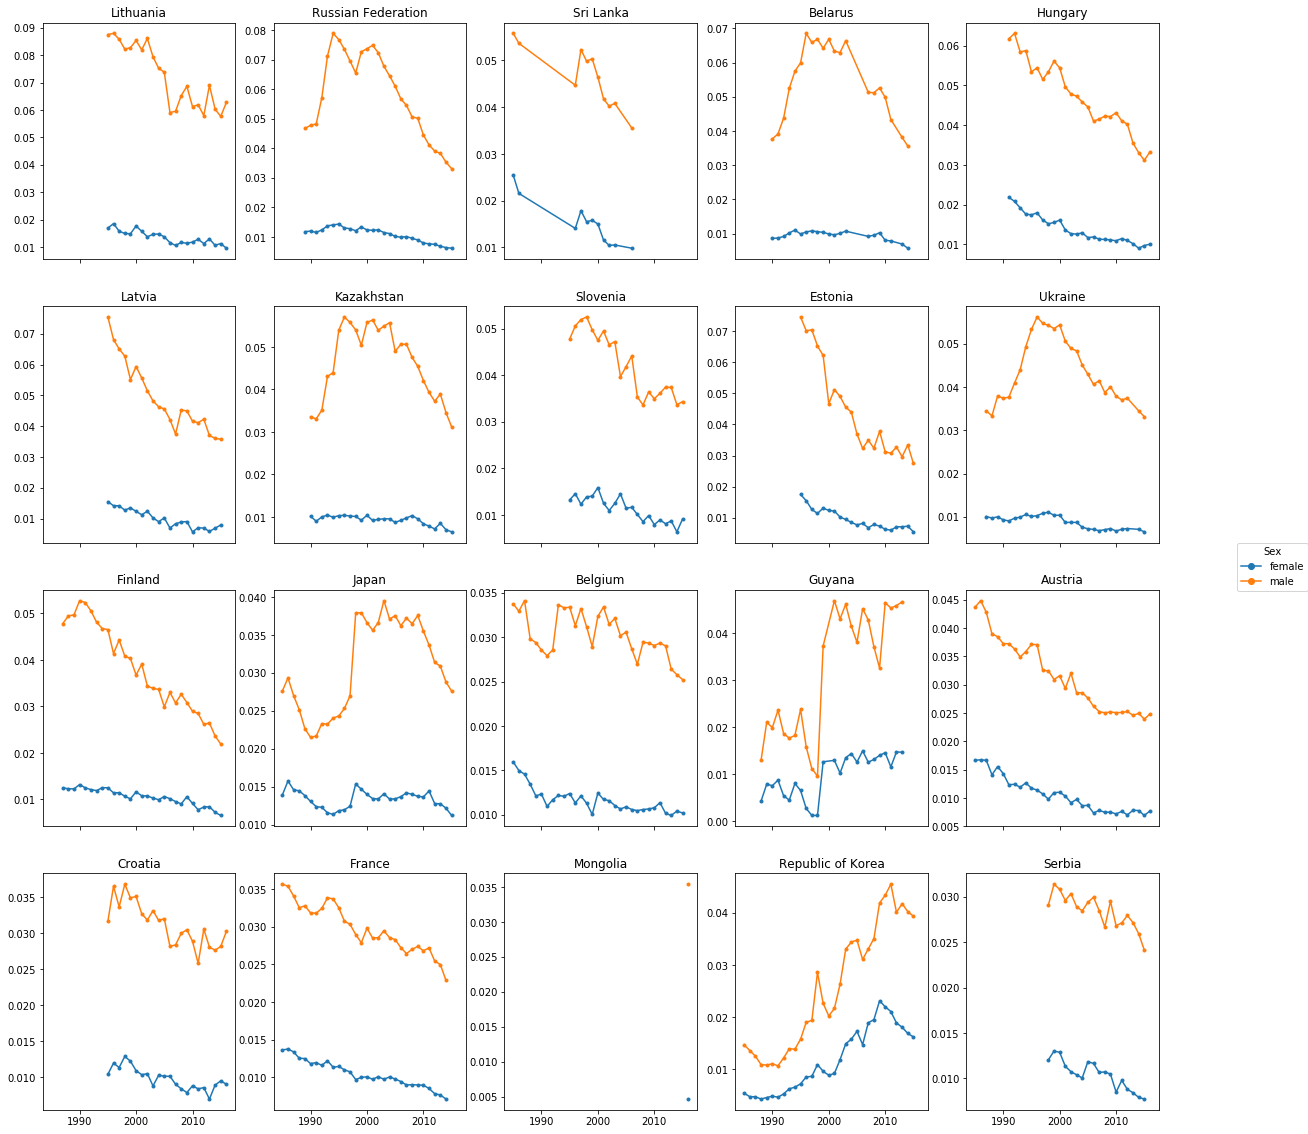

In [126]:
## see for the top 20 countries

fig, axs = plt.subplots(figsize=(20,20), nrows=4, ncols=5, sharex=True)
axs = axs.flatten()

for i in range(0, len(top20)):
    country = df.loc[df['country'].isin([top20_calc[i]])]
    country = country.groupby(['year','sex']).agg({'suicides_no': 'sum', 'population': 'sum'})
    country['suicide_rate'] = country['suicides_no'] / country['population'] * 100
    unstack_sex = country['suicide_rate'].unstack(['sex'])
    axs[i].plot(unstack_sex.index, unstack_sex[['female', 'male']], marker='.')
    axs[i].title.set_text(top20_calc[i])

# Create the legend
fig.legend(labels=['female', 'male'],   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Sex",  # Title for the legend
           markerscale=2.0)

plt.show()


So there is very high discriminating power between whether or not the person is male or female.  Males have much higher suicide rates in every one of the top 20 countries.

In [7]:
## first remove country year column
df.drop('country-year', axis=1, inplace=True)
print(df.columns)

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'HDI for year', ' gdp_for_year ($) ',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')


In [8]:
# rename ' gdp_for_year ($) ' as should not have padded spaces
df.rename(columns={' gdp_for_year ($) ': 'gdp_for_year ($)'}, inplace=True)

Let's see what other columns besides sex are categorical.

In [9]:
## check values for object columns
for col in df.columns:
    if df[col].dtype == np.object:
        print(col, df[col].unique())

country ['Albania' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria' 'Cabo Verde'
 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominica' 'Ecuador' 'El Salvador' 'Estonia'
 'Fiji' 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Grenada'
 'Guatemala' 'Guyana' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Kazakhstan' 'Kiribati' 'Kuwait' 'Kyrgyzstan' 'Latvia'
 'Lithuania' 'Luxembourg' 'Macau' 'Maldives' 'Malta' 'Mauritius' 'Mexico'
 'Mongolia' 'Montenegro' 'Netherlands' 'New Zealand' 'Nicaragua' 'Norway'
 'Oman' 'Panama' 'Paraguay' 'Philippines' 'Poland' 'Portugal'
 'Puerto Rico' 'Qatar' 'Republic of Korea' 'Romania' 'Russian Federation'
 'Saint Kitts and Nevis' 'Saint Lucia' 'Saint Vincent and Grenadines'
 'San Marino' 'Serbia' 'Seychelles' 'Singapore' 'Slovakia' 'Slovenia'


In [10]:
## change gdp_for_year ($) from string to integer
df['gdp_for_year ($)'] = df['gdp_for_year ($)'].str.replace(",", "").astype(float)

In [11]:
## check missing values also
df.head()
print(df.isnull().any())
print('\nMissing HDI % =', len(df[df['HDI for year'].isnull()])/len(df))

country               False
year                  False
sex                   False
age                   False
suicides_no           False
population            False
suicides/100k pop     False
HDI for year           True
gdp_for_year ($)      False
gdp_per_capita ($)    False
generation            False
dtype: bool

Missing HDI % = 0.699352983465133


In [12]:
## remove HDI because too much missing data!
df.drop('HDI for year', axis=1, inplace=True)

Now the homework assignment indicated to look at a histogram of `suicides/100k pop` but in order to do that we need to get a mean of each country's rate over the years.

Text(0.5, 1.0, 'Rate by Country')

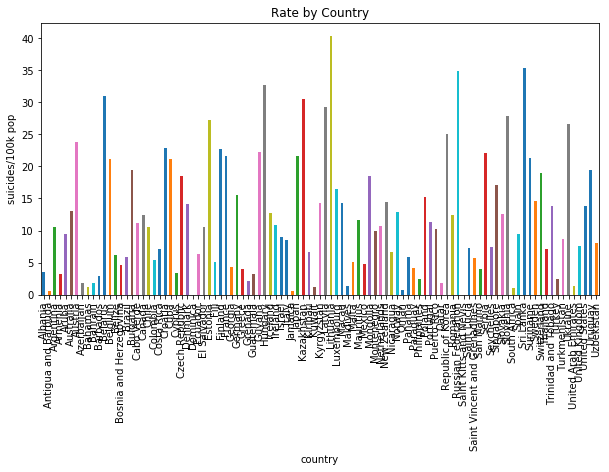

In [13]:
## see if suicide rate using suicides/100k is greater for different countries
country = df.groupby('country').agg({'suicides/100k pop' : 'mean'})
ax = country['suicides/100k pop'].plot.bar(figsize=(10,5))
ax.set_xlabel("country")
ax.set_ylabel("suicides/100k pop")
ax.set_title('Rate by Country')

There is definitely some discriminating power for the suicide rate by country.  We could group them by their continent but seems like over kill at the moment.  Continent would have been a good column to have added as well as whether or not wars could be going on with that country whether or not actually being fought in that country.  Since family deaths from war could increase depression and suicide rates.

This is partly for question number 5 but it is also relevant for question 1 for what information is important to "machine learn".  I am going to plot by `year` and show groups by `generation`, by `age`, and then just by `year` by itself.

C:\Users\bjwil\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


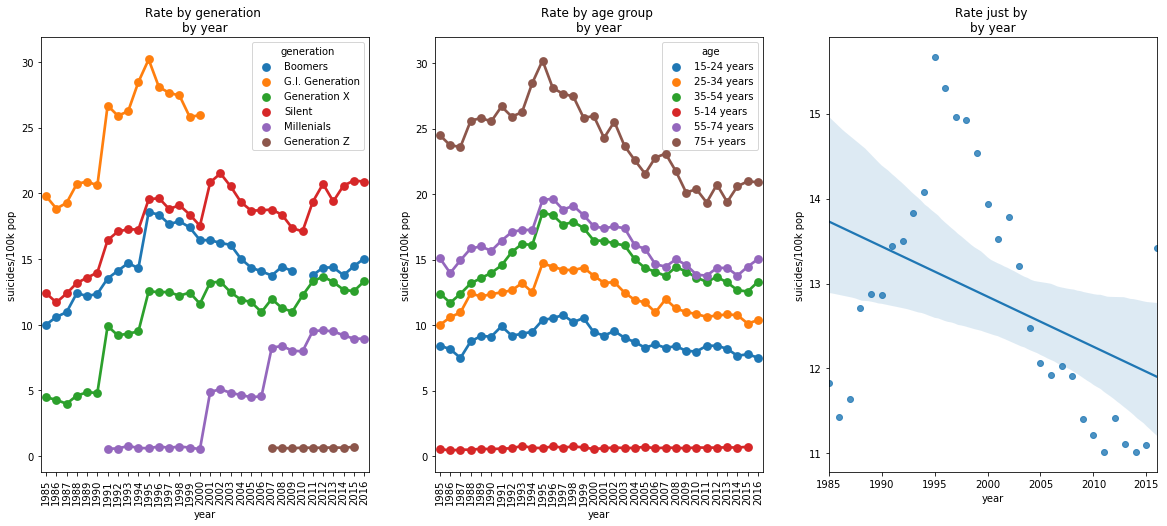

In [14]:
## see if suicides/100k is greater by year/generation/age globally as first plot for top 20 countries moves up & down

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

_year_gen = df.groupby(['year','generation']).agg({'suicides/100k pop' : 'mean'}).reset_index()
sns.pointplot(ax=ax1, x='year', y='suicides/100k pop', hue='generation', data=_year_gen, figsize=(5,15))
ax1.title.set_text('Rate by generation \nby year')
ax1.tick_params('x', labelrotation=90)

_year_age = df.groupby(['year','age']).agg({'suicides/100k pop' : 'mean'}).reset_index()
sns.pointplot(ax=ax2, x='year', y='suicides/100k pop', hue='age', data=_year_age, figsize=(5,15))
ax2.title.set_text('Rate by age group \nby year')
ax2.tick_params('x', labelrotation=90)

_year_only = df.groupby(['year']).agg({'suicides/100k pop' : 'mean'}).reset_index()
sns.regplot(ax=ax3, x='year', y='suicides/100k pop', data=_year_only)
ax3.title.set_text('Rate just by \nby year')

plt.show()

Looking at the graphs above it shows there is some good discriminating power between `suicides/100k pop` and `generation` as well as `suicides/100k pop` and `age` group.  There is also an overall trend downward in global suicide rates but the confidence interval is very wide and there was a big spike and fall over the years.  Not sure what the reason was for the last spike in 2016.  That sounds scary 😨.

I was interested to code the graphs from the resource that indicated how to `generation` was a derived column.  Pretty cool!  I am going to keep this column for my model but will OneHotEncode it.

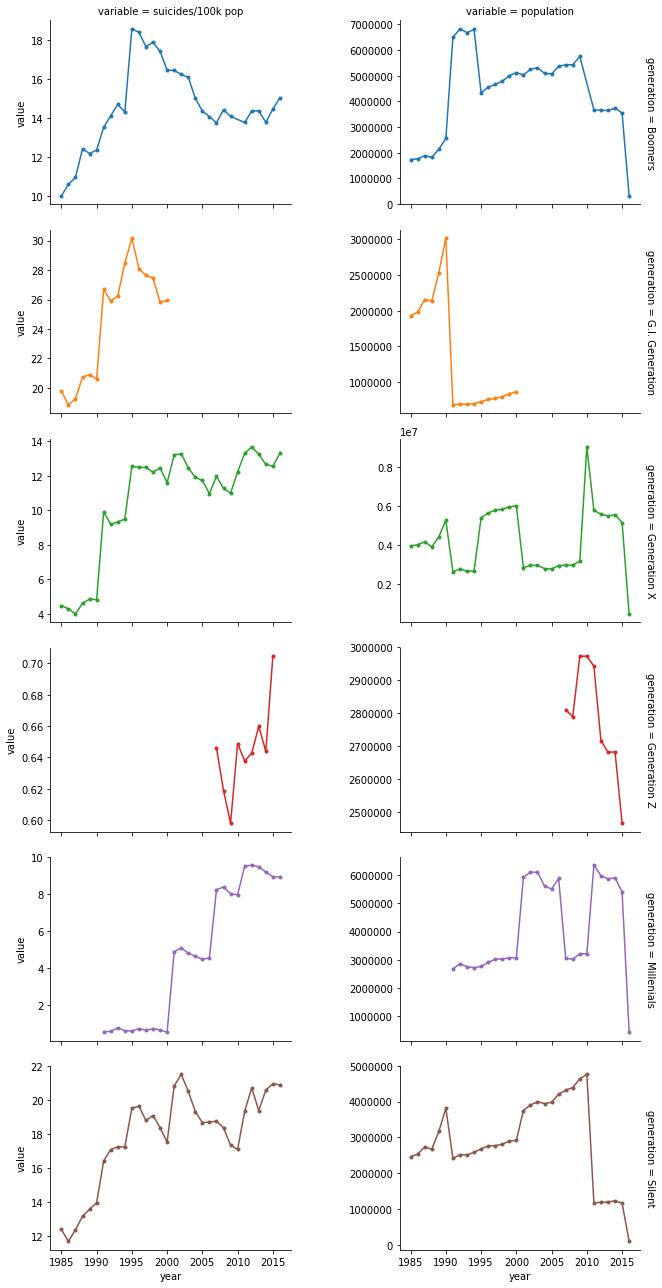

In [15]:
## charts from kaggle
_year_gen_ = df.groupby(['generation','year']).agg({'suicides/100k pop' : 'mean', 
                                                    'population' : lambda x: x.sum()/100}).reset_index()



melted = _year_gen_.melt(id_vars=['generation', 'year'], value_vars=['suicides/100k pop', 'population'])

g = sns.FacetGrid(melted, col='variable', hue='generation', row='generation', sharey=False, margin_titles=True)
g = (g.map(plt.plot, 'year', 'value', marker=".").set(xticks=range(1985, 2020, 5)))
g.fig.set_figwidth(10)

In order to do kernel densities as we did with the breast cancer dataset, I am going to create a new column for `suicides/100k pop` and create 5 bins.  However, I will later remove the bins columns as you will see why when I answer question 2 and 3 as I am not going to do a classification problem.  I will do kernel densities for columns `age` which needs to be mapped (see below for reason) as well as densities for `population`, `gdp_for_year ($)`, and  `gdp_per_capita ($)`.

In [16]:
## see why we need to use map instead of .astype('category').cat.codes
dict( enumerate(df['age'].astype('category').cat.categories ))

{0: '15-24 years',
 1: '25-34 years',
 2: '35-54 years',
 3: '5-14 years',
 4: '55-74 years',
 5: '75+ years'}

As you can see above it maps the lowest age group `5-14 years` is the 3rd category when I believe it should be the first.  We could OneHotEncode this but I believe it is ordinal and will have better learning efficiency being mapped to an ordinal order.

In [17]:
## see what categories would be for cutting the numerical 'suicides/100k pop' column
pd.cut(df['suicides/100k pop'], bins=5).astype('category').cat.categories

IntervalIndex([(-0.225, 44.994], (44.994, 89.988], (89.988, 134.982], (134.982, 179.976], (179.976, 224.97]]
              closed='right',
              dtype='interval[float64]')

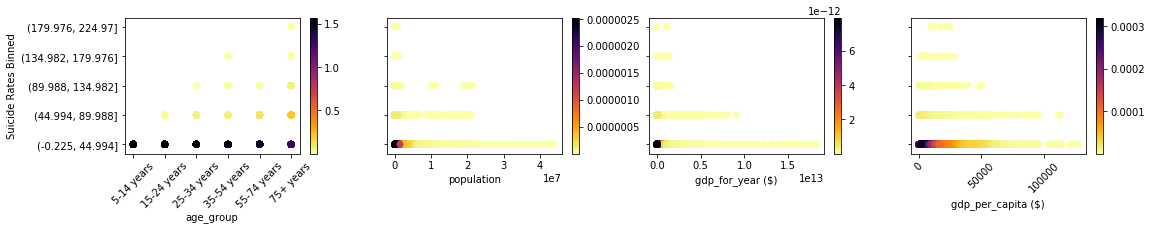

In [18]:
## kernel density for age group, population, gdp_for_year, gdp_per_capita
from scipy.stats import gaussian_kde

## first change to suicides/100k pop to levels and age to category float
#df['suicides/100k pop binned'] = pd.cut(df['suicides/100k pop'], bins=5).astype('category').cat.codes
df['suicides/100k pop binned'] = pd.cut(df['suicides/100k pop'], bins=5).astype('category')
## mapping age group because I want to preserve ordinal data for age
df['age_group float'] = df['age'].map({'5-14 years': 0, 
                                       '15-24 years': 1, 
                                       '25-34 years': 2, 
                                       '35-54 years': 3, 
                                       '55-74 years': 4, 
                                       '75+ years': 5})

# then plot for age groups
fig, axs = plt.subplots(1, 4, figsize=(18, 2.5), sharey=True)

# get colormap and make high densities darker color with _r
cm = plt.cm.get_cmap('inferno_r')

y = df['suicides/100k pop binned'].cat.codes.ravel()
xy = np.vstack([df['age_group float'], y]); z = gaussian_kde(xy)

sc = axs[0].scatter(df['age_group float'], y, c=z(xy), cmap=cm)
axs[0].set_xlabel("age_group")
axs[0].set_yticks(np.arange(len(df['suicides/100k pop binned'].cat.categories)))
axs[0].set_yticklabels(df['suicides/100k pop binned'].cat.categories)
axs[0].set_xticks(np.arange(len(df['age'].unique())))
axs[0].set_xticklabels([x for _,x in sorted(zip(df['age_group float'].unique(),df['age'].unique()))])
axs[0].tick_params('x', labelrotation=45)
axs[0].set_ylabel("Suicide Rates Binned")
fig.colorbar(sc, ax=axs[0])

xy = np.vstack([df['population'], y]); z = gaussian_kde(xy)
sc = axs[1].scatter(df['population'], y, c=z(xy), cmap=cm)
axs[1].set_xlabel("population")
fig.colorbar(sc, ax=axs[1])

xy = np.vstack([df['gdp_for_year ($)'], y]); z = gaussian_kde(xy)
sc = axs[2].scatter(df['gdp_for_year ($)'], y, c=z(xy), cmap=cm)
axs[2].set_xlabel("gdp_for_year ($)")
fig.colorbar(sc, ax=axs[2])

xy = np.vstack([df['gdp_per_capita ($)'], y]); z = gaussian_kde(xy)
sc = axs[3].scatter(df['gdp_per_capita ($)'], y, c=z(xy), cmap=cm)
axs[3].set_xlabel("gdp_per_capita ($)")
axs[3].tick_params('x', labelrotation=45)
fig.colorbar(sc, ax=axs[3])

In [19]:
# sanity check on the first graphs above to see that high densities are at low suicide rates
df['suicides/100k pop binned'].value_counts()

(-0.225, 44.994]      26154
(44.994, 89.988]       1365
(89.988, 134.982]       267
(134.982, 179.976]       29
(179.976, 224.97]         5
Name: suicides/100k pop binned, dtype: int64

As you can see above for age_group we start seeing some low density (light dots) in the higher Suicide rate bins 4 and 5 for ~135-180 `suicides/100k pop` and ~180-225 `suicides/100k pop` respectively as the age groups start increasing.  There is a dot for the 4th highest suicide bin at 4th oldest age group and there are dots at 4th and highest suicide bins for the oldest age group.  The lower suicide rates are spread pretty even, but seeing some light densities of higher suicide rates for older age groups does match the consensus in the middle line graph above "Rate by age group by year".

For the other three `population`, `gdp_for_year ($)`, and  `gdp_per_capita ($)`, it does tend to look like there are high densities of low suicide rates (good) at regions were the population and GDP are low but only at these low population and GDP numbers do we start to see light densities of high suicide rates



Returning back to question 1, the first plot of the

__2. [10 pts] Explain in detail how one should set up the problem? Would it be a regression or a classification problem? Any unsupervised approach to see some patterns exist or not?__

The problem, I believe is predicting the suicide rate give a certain amount of information, and this is a numerical data column.  I do not think it would be worth binning this column and making it a classification until the bonus question at the end when we want to predict a probability that a certain individual will commit suicide.  Although agreeing it is a very big problem, the rate on a per person basis is so low that it would be misinterpreted that he/she will not attempt or succeed in suicide.  Instead it would be easier to put in a plan to see if they fit into a group of people who have a high suicide rate, i.e. the column for `suicides/100k pop`.  As so we would need to run a linear regression to train the model for a prediction given an example as `suicides/100k pop` is numerical and a continuous scale.  To setup the problem one will have to determine which features are invalid as well as make all the columns numeric or binary, i.e. OneHotEncoding.  As far as I am aware and I have found the resources at the links below to confirm, there are not unsupervised approached when it comes to linear regression problems.

https://stats.stackexchange.com/questions/61390/is-there-unsupervised-regression
https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/ (comment by Jason Lee)

__3. [10 pts] What would be the dependent variable?__

The dependent variable should be `suicides/100k pop` so that we can, predict given an example, whether that example will produce a numerical rate equivalent those that fit the examples features.  We want to use this column rather than the column `suicides_no` because the rate is more relative to how large the population could be.   

__4. [10 pts] Rank the variables to find some strong correlations between the variables and the
dependent variable you set.__

We have already looked graphically and saw some correlations between generations and suicide rate as well as by age group suicide rate over the years.  We also saw some correlation between country graphically as well as correlation by year and by sex.  

We can numerically get a correlation between suicide rates the following:
* year.
* ordinal age group column we created `age_group float`
* generation if we map to a float category
* sex if we one OneHotEncode (just have column for male and lable 1 for male and 0 for female)
* population
* gdp_for_year ($)
* 
<p>

We could numerically get correlation by doing OneHotEncode for each country but that will be overkill. Let's look at some correlations.

In [20]:
## first we do some correlations to rank the feature, we already saw visually
## that there is some correlation with year and some discrimination between
## generations, countries as well as by sex but now we will look at correlation numbers

year = df.groupby('year').agg({'suicides/100k pop' : 'mean'}).reset_index()
print(year.corr())

age_group = df.groupby('age_group float').agg({'suicides/100k pop' : 'mean'}).reset_index()
print("\n", age_group.corr())

## need to map generation to float to get correlation but will OneHotEncode for Linear Regression
df['generation float'] = df['generation'].map({'Generation Z': 0, 
                                       'Millenials': 1, 
                                       'Generation X': 2, 
                                       'Boomers': 3, 
                                       'Silent': 4, 
                                       'G.I. Generation': 5})

generation = df.groupby('generation float').agg({'suicides/100k pop' : 'mean'}).reset_index()
print("\n", generation.corr())

sex =  pd.get_dummies(df, columns=['sex'], drop_first=True)
print('\n', sex.loc[:,['suicides/100k pop','sex_male']].corr())

## entire correlation for the continous variables
df_contin = df[['population', 'gdp_for_year ($)', 'gdp_per_capita ($)', 'suicides/100k pop']]

print('\n', df_contin.corr())



                       year  suicides/100k pop
year               1.000000          -0.400749
suicides/100k pop -0.400749           1.000000

                    age_group float  suicides/100k pop
age_group float           1.000000           0.967181
suicides/100k pop         0.967181           1.000000

                    generation float  suicides/100k pop
generation float            1.00000            0.99868
suicides/100k pop           0.99868            1.00000

                    suicides/100k pop  sex_male
suicides/100k pop           1.000000  0.391496
sex_male                    0.391496  1.000000

                     population  gdp_for_year ($)  gdp_per_capita ($)  \
population            1.000000          0.710697            0.081510   
gdp_for_year ($)      0.710697          1.000000            0.303405   
gdp_per_capita ($)    0.081510          0.303405            1.000000   
suicides/100k pop     0.008285          0.025240            0.001785   

                    su

Looking at the absolute values of the correlations we can rank as follows w.r.t. their correlation with the dependent variable:
* generation float = .99 (but we know from kaggle this could be an erroneous column, will deal with in #8.)
* age group = .97
* year = -.40 (this is negatively correlated)
* sex being a male = .39 (means positive correlation between higher suicide rate and 'male')
* gdp_for_year (\$) = .025
* population = .008
* gdp_per_capita (\$) = .001



C:\Users\bjwil\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


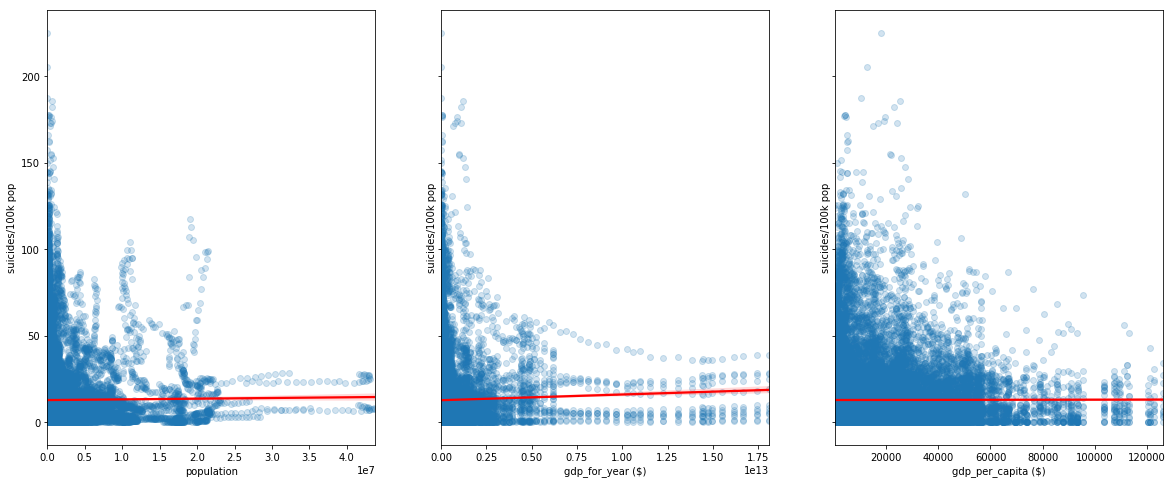

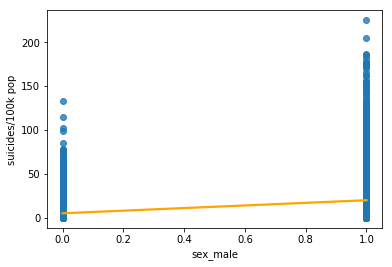

In [21]:
## the kde plot already shows this but just to reiterate.

fig, axs = plt.subplots(figsize=(20,8), nrows=1, ncols=3, sharey=True)

for i in range(3):
    sns.regplot(x=df_contin.columns[i], y='suicides/100k pop', data=df_contin, line_kws={'color': 'red'},
                 scatter_kws={'alpha' : .2}, ax=axs[i])
plt.show()

## the correlation above shows this also for sex 
sns.regplot(x='sex_male', y='suicides/100k pop', data=sex, line_kws={'color': 'orange'});

__5. [10 pts] Pre-process the dataset and list the major features you want to use. Note that not all features are crucial. For example, country-year variable is a derived feature and for a classifier it would not be necessary to include the year, the country and the country-year together. In fact, one must avoid adding a derived feature and the original at the same time.__

We already did a little bit of pre-processing above.  We converted the string value for the column `gdp_for_year ($)` to float type as well as remove the extra spaces from that column name.  We removed the column `HDI for year` because we saw it was missing nearly 70% of data for the rows.  We also already got rid of the column `country-year` because it was just concatenating two columns together.  Now since we added a mapped a column for age groups so that the age group is now an ordinal category [0:5], we will need to remove the categorical column `age` for the linear regression.  We also created a mapped column for generation  called for `generation float` and I want to remove this so I can later OneHotEncode `generation` as indicated why I felt this way above.  We also created a column above for binning the dependent variable called `suicides/100k pop binned` which I will remove.  Lastly as indicate in 3. we will remove the `suicides_no` column because this data is already contained in the dependent variable column `suicides/100k pop`.

In [22]:
## get df ready for linear regression

df_copy = sex.copy() ## we already OneHotEncoded the sex colum

## drop suicides_no as well as the binned for guassian_kde above because we have suicides/100k pop
## also drop age because we mapped to its ordinal data 'age_group float' also above
df_copy.drop(columns=['age', 'generation float', 'suicides/100k pop binned', 'suicides_no'], inplace=True)
df_copy.head()

,country,year,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),generation,age_group float,sex_male
0,Albania,1987,312900,6.71,2.156625e+09,796,Generation X,1,1
1,Albania,1987,308000,5.19,2.156625e+09,796,Silent,3,1
2,Albania,1987,289700,4.83,2.156625e+09,796,Generation X,1,0
3,Albania,1987,21800,4.59,2.156625e+09,796,G.I. Generation,5,1
4,Albania,1987,274300,3.28,2.156625e+09,796,Boomers,2,1


Now since we need all columns to be numerical to run a linear regression or support vector regression we need to additionally OneHotEncode `generation` and `country` in addition to the `sex` column we OneHotEncoded above.  Then develop the learning model to run.

In [23]:
## OneHotEncode generation as it overlaps multiple age groups and also OneHotEncode country
df_ohe = pd.get_dummies(df_copy, columns=['generation', 'country'], drop_first=True)
df_ohe.sample(10)

,year,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),age_group float,sex_male,generation_G.I. Generation,generation_Generation X,generation_Generation Z,...,country_Thailand,country_Trinidad and Tobago,country_Turkey,country_Turkmenistan,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan
12868,1991,4401300,3.23,1.242109e+12,22805,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15386,1991,32600,3.07,1.432188e+10,39465,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25098,1998,5480327,22.30,1.136757e+11,2005,2,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
19277,2009,4182592,8.13,4.397962e+11,12141,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22784,1993,76871,49.43,1.645220e+10,3334,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
26326,2008,5726858,8.43,1.799924e+11,4104,4,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1559,1996,1431200,32.91,4.003027e+11,23526,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3520,1991,783200,9.07,2.116378e+11,22523,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10798,1993,1392070,0.29,1.139994e+10,1381,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1487,1990,1415000,29.54,3.108380e+11,19665,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__6. [10 pts] Do you think there are two levels (categories) of the dependent variable?__

I don't believe there are two levels for the dependent variable because it is a continuous variable.  You could cut the variable in half at it's median and then label the lower half at a "low risk" and the higher half at a "high risk".  Actually now that I think of it, this won't give you a probability but it will give you an indicator if that person is within a group that are high risk of suicide.

__7. [10 pts] Can it be a regression model since the #suicide is numerical?___

This is a regression model since the dependent variable is a continuous numerical variable.

___8. [10 pts] Develop your model to solve your defined problem.___

I am going to build and try to run multiple regression classifiers: including LinearRegression, LinearSVR, and RandomForestRegressor.  I will use the columns `year`, `population`,	`gdp_for_year ($)`,	`gdp_per_capita ($)`, `age_group float`, `sex` as OneHotEncoded, `generation` as OneHotEncoded, `country` as OneHotEncoded as well as the dependent variable  `suicides/100k pop`.  I will do an 80/20 split for LinearRegression as well as 10 k-fold cross validations and then also compare 10 k-fold cross validations for LinearSVR and RandomForestRegressor after hyptertuning parameters for those two.  If the results are not so good we can try to remove the country column as it might not add a lot of value.  I also want to try doing a PCA analysis but I do not want to do that with all the country columns.  I will create a pipeline for PCA after removing country columns if the results after removing country columns is still poor.  I will also also standardize all the data.  For testing the 80/20 split I will standardize in the iterations but for the rest I will add StandardScaler() to the pipeline.  Also note that we have to shuffle before doing the k-fold because the data is in `country` and `year` order.

Lastly these are just models to test with the information in the dataset.  I noticed that for question #10 we do not have a lot of information and will select the model that is best for only those 4 features.


__9. [10 pts] Evaluate (and report) the model performance using some of the techniques in
module notebook (e.g. 80-20 split, 10-fold cross validation, etc.).__

First I will import what we need and test LinearRegression, LinearSVR, and RandomForestRegressor all with the column country.  

First up is Linear Regression.

LinearRegression 80% train-test split mean_squared_error is -174.421 ±8.0290
LinearRegression 80% train-test split r2 is 0.519 ±0.0117
LinearRegression 80% train-test split explained_variance is 0.519 ±0.0117


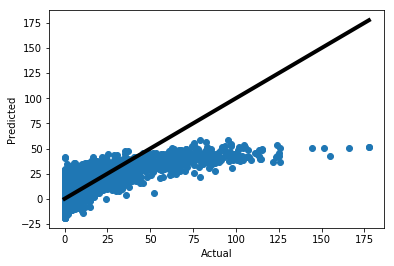

LinearRegression 10-fold cross validation test_neg_mean_squared_error is -176.286 ±18.0088
LinearRegression 10-fold cross validation test_r2 is 0.510 ±0.0103
LinearRegression 10-fold cross validation test_explained_variance is 0.510 ±0.0102


In [24]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

X = df_ohe.drop(columns='suicides/100k pop')
y = df_ohe['suicides/100k pop']

## test just running 50 times on 80/20 split w/o kfold
## note you must add a (-) if using mean_squared_error(y, pred) bc pipeline scoring does this
## see https://github.com/scikit-learn/scikit-learn/issues/2439
## so I just made negative here instead of hacking the rest in pipeline
accuracies = {'mean_squared_error' : [],
              'r2' : [],
              'explained_variance': []
             }

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=None
                                                       )

    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_scale, y_train)

    pred = lr.predict(X_test_scale)
    
    accuracies['mean_squared_error'].append(-mean_squared_error(y_test, pred))
    accuracies['r2'].append(r2_score(y_test, pred))
    accuracies['explained_variance'].append(explained_variance_score(y_test, pred))

for k, v in accuracies.items():
    print(f'LinearRegression 80% train-test split {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')
        


# plot example just to see how accurate the predictions are
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

## try pipeline with kfold of 10
lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
## must shuffle do to ordered data
kfold = KFold(n_splits=10, shuffle=True)
accuracies = cross_validate(lr_pipeline, X, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                                   'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearRegression 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')




Well that is a high mean_squared_error ~$\mid176\mid$.  It is very far from 0 which would be a perfect fit.  The $r^2$ value is around 0.5 which is not that good.  Let's see if LinearSVR works better but first let's hypertune the parameters for `C` and `epsilon`.

In [25]:
##try LinearSVR, but first hypertune params

LinSVR_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', LinearSVR(C=1.0, epsilon=0.2, max_iter=5000))
])

param_grid = dict(classifier__C=np.logspace(-2, 0, 3),
                  classifier__epsilon=[0., 0.2, 0.5])

grid = GridSearchCV(LinSVR_pipeline, param_grid=param_grid, cv=3, n_jobs=1, verbose=0, scoring='neg_mean_squared_error')
grid.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        LinearSVR(C=1.0, dual=True, epsilon=0.2,
                                                  fit_intercept=True,
                                                  intercept_scaling=1.0,
                                                  loss='epsilon_insensitive',
                                                  max_iter=5000,
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
                                verbose=False),
             iid='deprecated', n_jobs=1,
      

In [26]:
## what are best params for LinearSVR?
print(grid.score(X, y))
print(grid.best_score_)
print(grid.best_params_)

-224.1509346312678
-297.2922376032605
{'classifier__C': 0.01, 'classifier__epsilon': 0.5}


Well the absolute value of mean_squared_error is larger than (further away from 0) than LinearRegression so I would not expect the  $r^2$ value to be any better.  Let's try kfold cross-validation of 10 again for LinearSVR and then we will do RandomForestRegressor.  If they both fail to beat LinearRegression or are not much better then we can try them again without the country columns in the data.

In [27]:
## run LinearSVR pipe with best params
LinSVR_pipe = make_pipeline(StandardScaler(), LinearSVR(C=0.01, epsilon=0.5, max_iter=9000))
accuracies = cross_validate(LinSVR_pipe, X, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                                   'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearSVR 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

LinearSVR 10-fold cross validation test_neg_mean_squared_error is -226.095 ±8.7230
LinearSVR 10-fold cross validation test_r2 is 0.371 ±0.0066
LinearSVR 10-fold cross validation test_explained_variance is 0.407 ±0.0069


LinearSVR was not better than LinearRegression classifier.  Last up is RandomForestRegressor.  Lets tune for hyperparameters for `n_estimators`, `max_depth`, `max_features`.

In [28]:
from sklearn.ensemble import RandomForestRegressor

RFR_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', RandomForestRegressor(n_estimators=200, max_depth=5, random_state=0, max_features=10, n_jobs=4))
])

param_grid = dict(classifier__n_estimators=(100, 200),
                  classifier__max_depth=[5, 10],
                  classifier__max_features=[5, 10]
                 )

grid = GridSearchCV(RFR_pipeline, param_grid=param_grid, cv=3, n_jobs=1, verbose=0, scoring='neg_mean_squared_error')
grid.fit(X, y)
print(grid.score(X, y))
print(grid.best_params_)

-158.24834511290842
{'classifier__max_depth': 10, 'classifier__max_features': 10, 'classifier__n_estimators': 100}


Well the absolute value for mean_squared_error of 158.25 is less than that of LinearRegression which was around 176.  Now we can run the 10 k-fold cross validation using the best hyperparameters for RandomForestRegressor.

In [29]:
## run RandomForestRegressor pipe with best params
RFR_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, 
                                                                 max_depth=10, 
                                                                 random_state=0, 
                                                                 max_features=10, 
                                                                 n_jobs=4))
accuracies = cross_validate(RFR_pipe, X, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                               'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'RandomForestRegressor 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

RandomForestRegressor 10-fold cross validation test_neg_mean_squared_error is -167.746 ±12.4751
RandomForestRegressor 10-fold cross validation test_r2 is 0.533 ±0.0130
RandomForestRegressor 10-fold cross validation test_explained_variance is 0.533 ±0.0132


Well it looks like we just got lucky with having the a lower absolute value for mean_squared_error while tuning RandomForestRegressor.  RandomForestRegressor is not performing much better than LinearRegression.  The $r^2$ values is only slightly better than LinearRegression at around 0.53.  Let's remove the country column and try again.

In [30]:
## remove country
X_no_country = X.loc[:, ~X.columns.str.contains('country')]
X_no_country.head()

## try LinearRegression pipeline with kfold of 10 w/o country
lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
## must shuffle do to ordered data
kfold = KFold(n_splits=10, shuffle=True)
accuracies = cross_validate(lr_pipeline, X_no_country, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                                   'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearRegression 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')


LinearRegression 10-fold cross validation test_neg_mean_squared_error is -254.579 ±18.7142
LinearRegression 10-fold cross validation test_r2 is 0.292 ±0.0129
LinearRegression 10-fold cross validation test_explained_variance is 0.292 ±0.0128


In [31]:
## run LinearSVR pipeline with best params at kfold of 10 w/o country
LinSVR_pipe = make_pipeline(StandardScaler(), LinearSVR(C=0.01, epsilon=0.5, max_iter=9000))
accuracies = cross_validate(LinSVR_pipe, X_no_country, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                                   'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearSVR 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

LinearSVR 10-fold cross validation test_neg_mean_squared_error is -299.362 ±26.4587
LinearSVR 10-fold cross validation test_r2 is 0.168 ±0.0091
LinearSVR 10-fold cross validation test_explained_variance is 0.220 ±0.0070


In [32]:
%%time
## run RandomForestRegressor pipe with best params w/o country
RFR_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, 
                                                                 max_depth=10, 
                                                                 random_state=0, 
                                                                 max_features=10, 
                                                                 n_jobs=4))
accuracies = cross_validate(RFR_pipe, X_no_country, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                               'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'RandomForestRegressor 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

RandomForestRegressor 10-fold cross validation test_neg_mean_squared_error is -138.056 ±6.5958
RandomForestRegressor 10-fold cross validation test_r2 is 0.615 ±0.0208
RandomForestRegressor 10-fold cross validation test_explained_variance is 0.615 ±0.0208
Wall time: 35.2 s


Well LinearRegression and LinearSVR ran worse with the data reduction of removing countries (maybe I should add this to the discussion post for module 3?) but RandomForestRegressor was better after removing countries with mean squared error of 139 and $r^2$ of 0.61 and did not take too long to run.  Let's try it with further `max_depth` = 50 and 'auto' for `max_features`.

In [33]:
%%time
## run RandomForestRegressor pipe with best params w/o country
RFR_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, 
                                                                 max_depth=50, 
                                                                 random_state=0,  
                                                                 n_jobs=4))
accuracies = cross_validate(RFR_pipe, X_no_country, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                               'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'RandomForestRegressor 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

RandomForestRegressor 10-fold cross validation test_neg_mean_squared_error is -77.928 ±7.3000
RandomForestRegressor 10-fold cross validation test_r2 is 0.782 ±0.0226
RandomForestRegressor 10-fold cross validation test_explained_variance is 0.783 ±0.0224
Wall time: 1min 15s


Wow!  That was not too bad.  $\mid{mean\_squared\_error}\mid$ is 76.422 and $r^2$ is 0.788.  I am going to try to hypertune real fast with to see how many PCA components works best for RandomForestRegressor and then run one more time.  

In [34]:
from sklearn.decomposition import PCA

RFR_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0, n_jobs=4))
])

param_grid = {'pca__n_components': np.arange(1,8)}

grid = GridSearchCV(RFR_pipeline, param_grid=param_grid, cv=3, n_jobs=1, verbose=0, scoring='neg_mean_squared_error')
grid.fit(X_no_country, y)
print(grid.score(X_no_country, y))
print(grid.best_params_)

-178.98766048051695
{'pca__n_components': 7}


In [35]:
%%time
## get pca with 7 features
pca = PCA(n_components=7)
_pca_X_copy = pca.fit_transform(X_no_country)
_pca_X_copy_df = pd.DataFrame(data=_pca_X_copy)


## run RandomForestRegressor pipe on PCA() with best params w/o country
accuracies = cross_validate(RFR_pipe, _pca_X_copy_df, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                               'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'RandomForestRegressor 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

RandomForestRegressor 10-fold cross validation test_neg_mean_squared_error is -90.658 ±12.1778
RandomForestRegressor 10-fold cross validation test_r2 is 0.748 ±0.0261
RandomForestRegressor 10-fold cross validation test_explained_variance is 0.748 ±0.0262
Wall time: 2min 10s


The performance was slightly worse so we lost some information doing PCA for the RandomForestRegressor. However for the next question #10 we cannot use the PCA anyways because we do not have all the columns for which I am running my model.  I will fine tune a model for the next question for just those columns.  If we were given data for columns `year`, `sex`, `age`, `population`,	`gdp_for_year ($)`,	`gdp_per_capita ($)`, `generation` as well as the dependent variable  `suicides/100k pop` then we could do the PCA.

Now because we only have columns `year`, `generation`, `age`, and `gender` for the next question we are going to train only with these columns.  I don't think it would be useful to impute the data for the example for question #10 for columns `population`,	`gdp_for_year ($)`,	`gdp_per_capita ($)` even though their correlations were very low (see above graphs showing all these correlations <= .025).  So let's remove those three columns as well as `country` because we don't have that for #10 either and run the pipelines once more for LinearRegression, LinearSVR, and RandomForestRegressor.

In [36]:
## remove population, gdp_for_year ($), gdp_per_capita ($)
X_clean = X_no_country.loc[:, ~X_no_country.columns.str.contains('gdp_|population')]
X_clean.sample(10)

,year,age_group float,sex_male,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent
14026,2014,2,1,0,0,0,1,0
12763,2013,0,0,0,0,1,0,0
20027,2013,5,0,0,0,0,0,1
20116,2007,2,0,0,1,0,0,0
1774,2015,3,1,0,1,0,0,0
3809,2015,1,0,0,0,0,1,0
8735,2012,3,0,0,1,0,0,0
20240,1985,0,1,0,1,0,0,0
19070,1990,2,1,0,0,0,0,0
4081,2010,1,0,0,0,0,1,0


In [37]:
## try LinearRegression pipeline with kfold of 10 for clean data only needed for #10
lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
## must shuffle do to ordered data
kfold = KFold(n_splits=10, shuffle=True)
accuracies = cross_validate(lr_pipeline, X_clean, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                                   'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearRegression 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')
        
print()
## run LinearSVR pipeline with best params at kfold of 10 for clean data only needed for #10
LinSVR_pipe = make_pipeline(StandardScaler(), LinearSVR(C=0.01, epsilon=0.5, max_iter=9000))
accuracies = cross_validate(LinSVR_pipe, X_clean, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                                   'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearSVR 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')
        
print()
## run RandomForestRegressor pipe with best params w/o country
RFR_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, 
                                                                 max_depth=50, 
                                                                 random_state=0,  
                                                                 n_jobs=4))
accuracies = cross_validate(RFR_pipe, X_clean, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                               'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'RandomForestRegressor 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

LinearRegression 10-fold cross validation test_neg_mean_squared_error is -255.141 ±25.7953
LinearRegression 10-fold cross validation test_r2 is 0.290 ±0.0144
LinearRegression 10-fold cross validation test_explained_variance is 0.290 ±0.0143

LinearSVR 10-fold cross validation test_neg_mean_squared_error is -299.382 ±15.7265
LinearSVR 10-fold cross validation test_r2 is 0.167 ±0.0081
LinearSVR 10-fold cross validation test_explained_variance is 0.218 ±0.0086

RandomForestRegressor 10-fold cross validation test_neg_mean_squared_error is -238.494 ±15.8807
RandomForestRegressor 10-fold cross validation test_r2 is 0.335 ±0.0230
RandomForestRegressor 10-fold cross validation test_explained_variance is 0.336 ±0.0234


The results dramatically decrease when we remove the columns `population`, `gdp_for_year`($), `gdp_per_capita ($)` for our best classifier RandomForestRegressor.  It drops from $r^2$ of ~0.788 to just 0.337.  It seems like we need these columns for RandomForestRegressor which is surprising because we saw that the correlation was not very high for these columns and the dependent variable.  We also really need the country columns for LinearRegression and LinearSVR.

__10. [10 pts] Using your model, what is the predicted value of 'number of suicides / 100k' for
the input: "year=2000, generation=Generation X, age=20, gender=male"?__

I have created a sample X value for the the year=2000, age of 20 corresponds to age group 15-24 which I mapped to 1 for column `age_group float`, 1 for male (0 would be female) for `sex_male`, and for OneHotEncoded `generation` we have 0 for `generation_G.I. Generation`, 1 for `generation_Generation X`, 0 for `generation_Generation Z`, 0 for  `generation_Millenials` and 0 for `generation_Silent`.  After we run the prediction for this example, we will graph what the rate is for these characteristics as an average with respect to the entire dataset for the 4 columns that match the attributes in the example and see how far off it is.

In [38]:
# just to see how to setup the example "year=2000, generation=Generation X, age=20, gender=male"
print(X_clean.columns)
[(_,x) for _,x in sorted(zip(df['age_group float'].unique(),df['age'].unique()))]


Index(['year', 'age_group float', 'sex_male', 'generation_G.I. Generation',
       'generation_Generation X', 'generation_Generation Z',
       'generation_Millenials', 'generation_Silent'],
      dtype='object')


[(0, '5-14 years'),
 (1, '15-24 years'),
 (2, '25-34 years'),
 (3, '35-54 years'),
 (4, '55-74 years'),
 (5, '75+ years')]

In [39]:
## Question 10 example
X_example = np.array([2000, 1, 1, 0, 1, 0, 0, 0]).reshape(1, -1)

RFR_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, 
                                                                 max_depth=50, 
                                                                 random_state=0,  
                                                                 n_jobs=4))
RFR_pipe.fit(X_clean, y)
print('Prediction for example "year=2000, generation=Generation X, age=20, gender=male" is ', RFR_pipe.predict(X_example)[0])

Prediction for example "year=2000, generation=Generation X, age=20, gender=male" is  14.861043913749613


Let compare to the average of the dataset for columns that match this criteria.

In [40]:
df_example = df[(df['year'] == 2000) &
                (df['sex'] == 'male') &
                (df['generation'] == 'Generation X') &
                (df['age'] == '15-24 years')]
df_example['suicides/100k pop'].mean()

14.712441860465113

So we were not that far off from what the average is.  However we do not know what the features `population`, `gdp_for_year ($)`, `gdp_per_capita ($)` are for the person in this example.  We don't just want to know we were close to the average if these three features can have a large distribution.  If we graph the suicide rate with respect to each of these columns on a scatter plot let's see how distributed that are.  We already know they are distributed throughout the entire dataset.

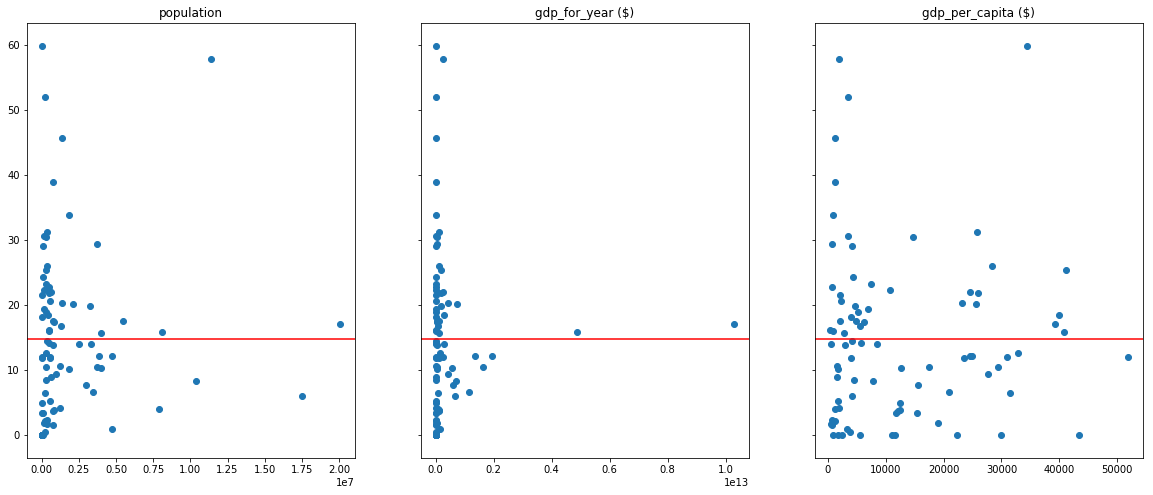

In [127]:
fig, axs = plt.subplots(figsize=(20,8), nrows=1, ncols=3, sharey=True)

axs[0].scatter(df_example['population'], df_example['suicides/100k pop'])
axs[0].axhline(df_example['suicides/100k pop'].mean(), color='r')
axs[0].set_title('population')
axs[1].scatter(df_example['gdp_for_year ($)'], df_example['suicides/100k pop'])
axs[1].axhline(df_example['suicides/100k pop'].mean(), color='r')
axs[1].set_title('gdp_for_year ($)')
axs[2].scatter(df_example['gdp_per_capita ($)'], df_example['suicides/100k pop'])
axs[2].axhline(df_example['suicides/100k pop'].mean(), color='r')
axs[2].set_title('gdp_per_capita ($)')

plt.show()

So as we have already noticed before, there is large spread of suicide rates when it comes to these three columns (also each dot is w.r.t a country).  There's not much correlation so we cannot really determine how accurate our prediction is with respect to the entire dataset given at the start if we do not have this information.  The redline is the average which is what are prediction was close to.

__11. [20 pts bonus] Using your (perhaps a different?) model, what is the probability a Generation
X 20-year-old male living in a country with 40000 gdp_per_capita would commit suicide?__

Now since we have the column information for `gdp_per_capita ($)` we can add this back into the model but we do not have the `year` so we will replace the column `year` in our model with `gdp_per_capita ($)` and compare the three regression models again to see the best performing.  Then we can run a prediction on this example and then compare it to the average for countries based on the criteria in the question (20 year old male in Gen X) that are within for all the years average of $10000 of 40000.  Finding the probability from our model is the easy part.  Whatever the prediction is for `suicides/100k pop` just divide that number by 100k.

In [42]:
X_gdp_per_capita = X_no_country.drop(columns=['year', 'population', 'gdp_for_year ($)']).copy()
X_gdp_per_capita.head()

,gdp_per_capita ($),age_group float,sex_male,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent
0,796,1,1,0,1,0,0,0
1,796,3,1,0,0,0,0,1
2,796,1,0,0,1,0,0,0
3,796,5,1,1,0,0,0,0
4,796,2,1,0,0,0,0,0


In [43]:
## try LinearRegression pipeline with kfold of 10 for clean data only needed for #10
lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
## must shuffle do to ordered data
kfold = KFold(n_splits=10, shuffle=True)
accuracies = cross_validate(lr_pipeline, X_gdp_per_capita, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                                   'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearRegression 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')
        
print()
## run LinearSVR pipeline with best params at kfold of 10 for clean data only needed for #10
LinSVR_pipe = make_pipeline(StandardScaler(), LinearSVR(C=0.01, epsilon=0.5, max_iter=9000))
accuracies = cross_validate(LinSVR_pipe, X_gdp_per_capita, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                                   'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearSVR 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')
        
print()
## run RandomForestRegressor pipe with best params w/o country
RFR_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, 
                                                                 max_depth=50, 
                                                                 random_state=0,  
                                                                 n_jobs=4))
accuracies = cross_validate(RFR_pipe, X_gdp_per_capita, y, cv=kfold, scoring=['neg_mean_squared_error',
                                                               'r2', 'explained_variance'])

for k, v in accuracies.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'RandomForestRegressor 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

LinearRegression 10-fold cross validation test_neg_mean_squared_error is -255.706 ±22.6923
LinearRegression 10-fold cross validation test_r2 is 0.289 ±0.0127
LinearRegression 10-fold cross validation test_explained_variance is 0.289 ±0.0127

LinearSVR 10-fold cross validation test_neg_mean_squared_error is -300.221 ±27.6021
LinearSVR 10-fold cross validation test_r2 is 0.165 ±0.0090
LinearSVR 10-fold cross validation test_explained_variance is 0.218 ±0.0080

RandomForestRegressor 10-fold cross validation test_neg_mean_squared_error is -289.111 ±17.6533
RandomForestRegressor 10-fold cross validation test_r2 is 0.195 ±0.0322
RandomForestRegressor 10-fold cross validation test_explained_variance is 0.196 ±0.0321


This time LinearRegression was the best so we will fit and predict with this classifier.

In [44]:
lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
lr_pipeline.fit(X_gdp_per_capita, y)

X_example = np.array([40000, 1, 1, 0, 1, 0, 0, 0]).reshape(1, -1)
print("Generation X 20-year-old male living in a country with 40000 gdp_per_capita prediction is",
      lr_pipeline.predict(X_example)[0])
print('Probability that example will commit suicide is {}%'.format(round(lr_pipeline.predict(X_example)[0]/100000*100, 4)))

Generation X 20-year-old male living in a country with 40000 gdp_per_capita prediction is 15.548570323252815
Probability that example will commit suicide is 0.0155%


In [45]:
df_11 = df[(df['sex'] == 'male') &
   (df['generation'] == 'Generation X') &
   (df['age'] == '15-24 years')]

df_11_avg_per_capita = df_11.groupby(['country']).agg({'gdp_per_capita ($)' : 'mean'})

countries = df_11_avg_per_capita[df_11_avg_per_capita['gdp_per_capita ($)'].between(30000, 50000)].index

## What is average for these countries and is prediction close?
avg_suicide_countrys_near_40000 = df_11[df_11['country'].isin(countries)].groupby('country').agg({'suicides/100k pop' : 'mean'})
print('average', avg_suicide_countrys_near_40000.mean())
print(avg_suicide_countrys_near_40000['suicides/100k pop'])

average suicides/100k pop    14.634967
dtype: float64
country
Denmark        12.208571
Japan          12.026875
Luxembourg     18.223750
Norway         23.898667
San Marino      0.000000
Sweden         14.013571
Switzerland    22.073333
Name: suicides/100k pop, dtype: float64


So the prediction again was near average but as you can see by these rich countries, the spread is still pretty distributed.  My overall outcome is that more information is needed for the example give to predict.  We need at least all the information for the features for the prediction that are in the original dataset, not necessarily the country for RandomForestRegressor, and even then our best accuracy of having $r^2$ of 0.78 for RandomForestRegressor and 0.51 for LinearRegression.  My thoughts are we need much more information to be able to "machine learn" for this dataset.  My thoughts are to obtain more information with respect to Public Mental Health databases that could give more insight into features that determine quality of life other than those features we have.